<a href="https://colab.research.google.com/github/zeynepaydin34/Baker/blob/main/Classification-Cleaning_Augmentation_Training_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Adım: Drive'ı bağla ve veri yükle
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import re
import string
import unicodedata
import nltk

nltk.download('stopwords', quiet=True)

TEXT_COLUMN = 'temizlenmis_metin'
ANA_KATEGORILER = ['ÜCRET İADESİ','BAGAJ','MÜŞTERİ HİZMETLERİ','UYGULAMA/TEKNİK','RÖTAR']

# Dosya yolu
DOSYA_ADI = '/content/drive/MyDrive/BİTİRME/Labeled_Data.xlsx'

# Veri yükle
df = pd.read_excel(DOSYA_ADI)
df.columns = [col.strip().replace(' ', '').replace('İ', 'I') for col in df.columns]

# Metin birleştirme
df['metin'] = df[['Baslik', 'Icerik', 'Kategori1', 'Kategori2']].fillna('').agg(' '.join, axis=1)

# Temizlik için stopwords
stop_words_tr = set(nltk.corpus.stopwords.words('turkish'))
ek_stop_words = {'rica', 'bilgi', 'olay', 'durum', 'yapmak', 'etmek', 'olmak',
                 'süre', 'değil', 'gerekli', 'taraf', 'istemek', 'istiyorum', 'yapılmasını',
                 'gerek', 'nedeniyle', 'a', 'o', 'bu', 'ki', 'için', 'ile', 've', 'ya', 'bir',
                 'ben', 'sen', 'biz', 'siz'}
stop_words_tr.update(ek_stop_words)

# Temizlik fonksiyonları
def nlp_clean(text):
    if pd.isna(text) or text is None: return ""
    text = str(text).lower()
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = re.sub(r'[\d€$₺£]', ' ', text)
    text = re.sub(r'\s*\S+@\S+|\s*https?://\S+|\s*www\.\S+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    kelimeler = text.split()
    kelimeler = [k for k in kelimeler if k not in stop_words_tr]
    return " ".join(kelimeler).strip()

def fix_unicode(text):
    replacements = {'i̇': 'i', 'I': 'ı', 'İ': 'i', 'Ö': 'ö', 'Ü': 'ü', 'Ç': 'ç', 'Ş': 'ş', 'Ğ': 'ğ'}
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    return text.strip()

# Temizleme uygula
df[TEXT_COLUMN] = df['metin'].apply(nlp_clean).apply(fix_unicode)

# Minimum filtreleme
df = df[df[TEXT_COLUMN].str.split().str.len() > 3]
df = df.dropna(subset=['Kategori1'])

# Multi-label encoding
for kategori in ANA_KATEGORILER:
    df[kategori] = ((df['Kategori1'] == kategori) | (df['Kategori2'] == kategori)).astype(int)

print(f"✅ Temizlik tamamlandı. Satır sayısı: {len(df)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Temizlik tamamlandı. Satır sayısı: 1048


In [ ]:
# 3. ADIM: Veriyi Ayırma (Train, Validation, Test: 80-10-10)

from sklearn.model_selection import train_test_split

# Metinleri ve etiketleri ayır
X = df[TEXT_COLUMN]  # df_clean yerine df kullan
y = df[ANA_KATEGORILER]

# 80% Train/Val, 10% Test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# Kalan %90'ı 8/1 oranında Train ve Val olarak ayır (yani 80% Train, 10% Val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=(0.1/0.9), random_state=42
)

# DataFrame oluştur
train_df = pd.DataFrame({TEXT_COLUMN: X_train, **y_train}).reset_index(drop=True)
val_df = pd.DataFrame({TEXT_COLUMN: X_val, **y_val}).reset_index(drop=True)
test_df = pd.DataFrame({TEXT_COLUMN: X_test, **y_test}).reset_index(drop=True)

print(f"Veri Seti Boyutları: Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print("\n✅ Veri ayırma (Train/Val/Test) tamamlandı. Sınıf Ağırlığı Hesaplamasına geçebilirsiniz.")


Veri Seti Boyutları: Train: 838, Val: 105, Test: 105

✅ Veri ayırma (Train/Val/Test) tamamlandı. Sınıf Ağırlığı Hesaplamasına geçebilirsiniz.


In [ ]:
# =========================================================
# Multi-label Dengeli Oversampling (Iteratif)
# =========================================================
import pandas as pd
import random
from deep_translator import GoogleTranslator
import torch
import os

# GPU kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Çalışma cihazı: {device}")

# Back-Translation Fonksiyonu (CPU'da çalışır)
def back_translate(text, src='tr', mid='en'):
    try:
        trans = GoogleTranslator(source=src, target=mid).translate(text)
        back = GoogleTranslator(source=mid, target=src).translate(trans)
        if back is None or back.lower().strip() == text.lower().strip():
            return text
        return back
    except Exception:
        return text

# Hedef sınıf sayısını belirle (en büyük sınıf)
MAX_CLASS_COUNT = train_df[ANA_KATEGORILER].sum().max()
print("="*60)
print("Başlatılıyor: Dengeli Oversampling + Back-Translation (Multi-label)")
print(f"Orijinal TRAIN SETİ boyutu: {len(train_df)}")
print(f"En büyük sınıf sayısı (hedef): {MAX_CLASS_COUNT}")
print("="*60)

# Iteratif oversampling
augmented_frames = []

# Kopya ekleme fonksiyonu
def add_sample(row):
    new_row = row.copy()
    new_row[TEXT_COLUMN] = back_translate(row[TEXT_COLUMN])
    return new_row

# Tüm sınıfların hedefe ulaşana kadar iteratif ekleme
while True:
    label_counts = train_df[ANA_KATEGORILER].sum()
    min_class = label_counts.idxmin()
    min_count = label_counts.min()

    if min_count >= MAX_CLASS_COUNT:
        break  # Tüm sınıflar hedefe ulaştı

    # Min sınıftan bir örnek seç
    candidates = train_df[train_df[min_class] == 1]
    row = candidates.sample(n=1, replace=True).iloc[0]
    new_row = add_sample(row)
    train_df = pd.concat([train_df, pd.DataFrame([new_row])], ignore_index=True)

print("\n✅ Oversampling tamamlandı.")
print(f"Yeni TRAIN SETİ boyutu: {len(train_df)}")
print("Yeni sınıf dağılımları:")
print(train_df[ANA_KATEGORILER].sum().sort_values(ascending=False).to_string())
print("="*60)

# Kaydetme
save_dir = '/content/drive/MyDrive/BİTİRME'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'train_augmented_multi_label_balanced.xlsx')
train_df.to_excel(save_path, index=False)
print(f"\n✅ Artırılmış ve dengeli TRAIN SETİ başarıyla kaydedildi: {save_path}")


✅ Çalışma cihazı: cuda
Başlatılıyor: Dengeli Oversampling + Back-Translation (Multi-label)
Orijinal TRAIN SETİ boyutu: 1889
En büyük sınıf sayısı (hedef): 966

✅ Oversampling tamamlandı.
Yeni TRAIN SETİ boyutu: 3142
Yeni sınıf dağılımları:
ÜCRET İADESİ          1487
MÜŞTERİ HİZMETLERİ    1022
BAGAJ                  967
UYGULAMA/TEKNİK        966
RÖTAR                  966

✅ Artırılmış ve dengeli TRAIN SETİ başarıyla kaydedildi: /content/drive/MyDrive/BİTİRME/train_augmented_multi_label_balanced.xlsx


In [ ]:

# 5. ADIM: Sınıflandırma Model Hazırlığı (Dengelenmiş Veri Seti İçin Optimizasyon)

import torch.nn as nn
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.metrics import f1_score, accuracy_score
import torch
import pandas as pd
# NOT: MODEL_NAME, ANA_KATEGORILER, TRAIN_BATCH, EVAL_BATCH, MAX_LEN, TEXT_COLUMN
# ve train_df, val_df değişkenlerinin tanımlı olduğunu varsayıyoruz.

# Cihazı Belirle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 5.1. Ağırlık Hesaplama (SADECE KONTROL AMAÇLI TUTULDU - KULLANILMAYACAK)
label_counts = train_df[ANA_KATEGORILER].sum()
print("\n✅ Artırma Sonrası Yeni Sınıf Sayımları (Dengeli Olmalı):")
print(label_counts.sort_values(ascending=False).to_string())
# Not: Aşağıdaki class_weights_tensor artık CustomTrainer'da kullanılmayacaktır.
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)


# 5.2. Custom Trainer (Ağırlığı DEVRE DIŞI BIRAKMAK için)
# Veri dengelemesi yapıldığı için, ağırlıklı Loss kaldırıldı.
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # 🚨 DÜZELTME: Ağırlıksız Loss Hesaplama
        # Artık train_df dengeli olduğu için pos_weight parametresi kaldırıldı.
        loss_fct = nn.BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# 5.3. Dataset Hazırlığı (Aynı kalıyor)
class ComplaintDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts.tolist()
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# Tokenizer ve Dataset Hazırlığı
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
train_dataset = ComplaintDataset(train_df[TEXT_COLUMN], train_df[ANA_KATEGORILER], tokenizer, max_len=MAX_LEN)
val_dataset = ComplaintDataset(val_df[TEXT_COLUMN], val_df[ANA_KATEGORILER], tokenizer, max_len=MAX_LEN)

# Temel BERT modelini yükle
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=len(ANA_KATEGORILER)
)
model.to(device)


# Metrik Hesaplama Fonksiyonu
def compute_metrics(pred):
    labels = pred.label_ids
    # Tahmin olasılıkları hesaplanır
    preds = torch.sigmoid(torch.tensor(pred.predictions)).numpy()
    # Varsayılan eşik 0.5 kullanılır
    preds = (preds > 0.5).astype(int)
    # Metrikler hesaplanır
    f1 = f1_score(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {"f1": f1, "accuracy": acc}

# Eğitim Parametreleri ve Custom Trainer'ı Oluştur
training_args = TrainingArguments(
    output_dir='./results', num_train_epochs=12, per_device_train_batch_size=TRAIN_BATCH,
    per_device_eval_batch_size=EVAL_BATCH,
    # Hata çözüldüğü için burayı tekrar True yapabiliriz, ancak şimdilik False kalsın
    gradient_checkpointing=False,
    logging_steps=50,
    learning_rate=1e-5, weight_decay=0.01, load_best_model_at_end=False,
    logging_dir='./logs', report_to='none', fp16=True if device.type == 'cuda' else False
)

# Custom Trainer'ı kullan
trainer = CustomTrainer(
    model=model, args=training_args, train_dataset=train_dataset,
    eval_dataset=val_dataset, compute_metrics=compute_metrics
)

print("\n✅ Custom Trainer ve Model objeleri başarıyla oluşturuldu. Eğitime başlamaya hazırsınız.")

In [ ]:
# ======================================================================
# 5-7. ADIM: Dengeli Multi-label Eğitim, Kaydetme ve Test Değerlendirme
# ======================================================================
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score, classification_report
import pandas as pd
import os

# -------------------------------
# 0. Varsayılan değişkenler
# -------------------------------
MODEL_NAME = "dbmdz/bert-base-turkish-cased"
ANA_KATEGORILER = ['ÜCRET İADESİ','BAGAJ','MÜŞTERİ HİZMETLERİ','UYGULAMA/TEKNİK','RÖTAR']
TEXT_COLUMN = 'temizlenmis_metin'
MAX_LEN = 128
TRAIN_BATCH = 8
EVAL_BATCH = 8


# Cihazı Belirle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Çalışma cihazı: {device}")

# -------------------------------
# 1. Ağırlık kontrolü (sadece bilgi)
# -------------------------------
label_counts = train_df[ANA_KATEGORILER].sum()
print("\n✅ Artırma Sonrası Yeni Sınıf Sayımları (Dengeli Olmalı):")
print(label_counts.sort_values(ascending=False).to_string())

# -------------------------------
# 2. Custom Trainer (Ağırlıksız Loss)
# -------------------------------
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.BCEWithLogitsLoss()  # pos_weight kaldırıldı
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# -------------------------------
# 3. Dataset Sınıfı
# -------------------------------
class ComplaintDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# -------------------------------
# 4. Tokenizer ve Dataset
# -------------------------------
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
train_dataset = ComplaintDataset(train_df[TEXT_COLUMN], train_df[ANA_KATEGORILER], tokenizer, max_len=MAX_LEN)
val_dataset = ComplaintDataset(val_df[TEXT_COLUMN], val_df[ANA_KATEGORILER], tokenizer, max_len=MAX_LEN)
test_dataset = ComplaintDataset(test_df[TEXT_COLUMN], test_df[ANA_KATEGORILER], tokenizer, max_len=MAX_LEN)

# -------------------------------
# 5. Model Yükleme
# -------------------------------
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(ANA_KATEGORILER))
model.to(device)

# -------------------------------
# 6. Metrik Fonksiyonu
# -------------------------------
def compute_metrics(pred):
    labels = pred.label_ids
    preds = torch.sigmoid(torch.tensor(pred.predictions)).numpy()
    preds = (preds > 0.5).astype(int)
    f1 = f1_score(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {"f1": f1, "accuracy": acc}

# -------------------------------
# 7. Eğitim Parametreleri
# -------------------------------
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/BİTİRME/results',
    num_train_epochs=12,
    per_device_train_batch_size=TRAIN_BATCH,
    per_device_eval_batch_size=EVAL_BATCH,
    gradient_checkpointing=False,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=0.01,
    load_best_model_at_end=False,
    logging_dir='/content/drive/MyDrive/BİTİRME/logs',
    report_to='none',
    fp16=True if device.type=='cuda' else False
)

# -------------------------------
# 8. Trainer
# -------------------------------
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# -------------------------------
# 9. Eğitim Başlat
# -------------------------------
print("\n" + "="*50)
print(f"BERT Model Eğitimi BAŞLIYOR... (Batch Size: {TRAIN_BATCH})")
print("="*50)
trainer.train()

# -------------------------------
# 10. Model ve Tokenizer Kaydet
# -------------------------------
save_path = '/content/drive/MyDrive/BİTİRME/trained_bert_multi_label'
os.makedirs(save_path, exist_ok=True)
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"\n✅ Eğitim tamamlandı. Model ve tokenizer '{save_path}' klasörüne kaydedildi.")

# -------------------------------
# 11. Test Seti Değerlendirme
# -------------------------------
print("\n" + "="*50)
print("TEST SETİ ÜZERİNDE PERFORMANS DEĞERLENDİRMESİ")
print("="*50)

results = trainer.evaluate(test_dataset)
print("\n✅ Genel Test Metrikleri:")
print(results)

# Tahminleri al
predictions = trainer.predict(test_dataset)
test_labels = predictions.label_ids
test_preds = torch.sigmoid(torch.tensor(predictions.predictions)).numpy()
test_preds_binary = (test_preds > 0.5).astype(int)

print("\n✅ Detaylı Sınıflandırma Raporu (Sınıf Bazlı Performans):")
print(classification_report(test_labels, test_preds_binary, target_names=ANA_KATEGORILER, zero_division=0))



✅ Çalışma cihazı: cuda

✅ Artırma Sonrası Yeni Sınıf Sayımları (Dengeli Olmalı):
ÜCRET İADESİ          1487
MÜŞTERİ HİZMETLERİ    1022
BAGAJ                  967
UYGULAMA/TEKNİK        966
RÖTAR                  966


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERT Model Eğitimi BAŞLIYOR... (Batch Size: 8)


Step,Training Loss
50,0.631000
100,0.542500
150,0.457600
200,0.400900
250,0.360900
300,0.324300
350,0.298500
400,0.275300
450,0.243000
500,0.223900



✅ Eğitim tamamlandı. Model ve tokenizer '/content/drive/MyDrive/BİTİRME/trained_bert_multi_label' klasörüne kaydedildi.

TEST SETİ ÜZERİNDE PERFORMANS DEĞERLENDİRMESİ



✅ Genel Test Metrikleri:
{'eval_loss': 0.3546130955219269, 'eval_f1': 0.8389057750759878, 'eval_accuracy': 0.6285714285714286, 'eval_runtime': 0.5806, 'eval_samples_per_second': 180.856, 'eval_steps_per_second': 24.114, 'epoch': 12.0}

✅ Detaylı Sınıflandırma Raporu (Sınıf Bazlı Performans):
                    precision    recall  f1-score   support

      ÜCRET İADESİ       0.84      0.86      0.85        59
             BAGAJ       0.95      1.00      0.98        21
MÜŞTERİ HİZMETLERİ       0.79      0.83      0.81        41
   UYGULAMA/TEKNİK       0.79      0.72      0.75        32
             RÖTAR       0.90      0.82      0.86        11

         micro avg       0.84      0.84      0.84       164
         macro avg       0.85      0.85      0.85       164
      weighted avg       0.84      0.84      0.84       164
       samples avg       0.86      0.86      0.84       164



In [ ]:
# ======================================================================
# Performans Analizi: ROC, Confusion Matrix, Inference Time
# ======================================================================

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import os

# -------------------------------
# 0. Model ve Tokenizer Yolu
# -------------------------------
model_path = '/content/drive/MyDrive/BİTİRME/trained_bert_multi_label'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# -------------------------------
# 1. Dataset Sınıfı
# -------------------------------
class ComplaintDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# -------------------------------
# 2. Test Dataset ve DataLoader
# -------------------------------
test_dataset = ComplaintDataset(test_df[TEXT_COLUMN], test_df[ANA_KATEGORILER], tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=EVAL_BATCH)

# -------------------------------
# 3. Tahmin ve Inference Time
# -------------------------------
all_labels = []
all_preds = []

start_time = time.time()
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k,v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.sigmoid(logits)
        all_preds.append(probs.cpu())
        all_labels.append(labels.cpu())

inference_time = time.time() - start_time
print(f"\n✅ Toplam inference süresi: {inference_time:.4f} saniye")

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()
all_preds_binary = (all_preds > 0.5).astype(int)

# -------------------------------
# 4. Genel ve Sınıf Bazlı Performans
# -------------------------------
f1_micro = f1_score(all_labels, all_preds_binary, average='micro')
accuracy = accuracy_score(all_labels, all_preds_binary)
print(f"\n✅ Genel F1 (micro): {f1_micro:.4f}")
print(f"✅ Genel Accuracy: {accuracy:.4f}")
print("\n✅ Detaylı Sınıf Bazlı Rapor:")
print(classification_report(all_labels, all_preds_binary, target_names=ANA_KATEGORILER, zero_division=0))

# -------------------------------
# 5. ROC Eğrileri ve AUC
# -------------------------------
os.makedirs('/content/drive/MyDrive/BİTİRME/metrics', exist_ok=True)
plt.figure(figsize=(10,8))

for i, label in enumerate(ANA_KATEGORILER):
    fpr, tpr, _ = roc_curve(all_labels[:,i], all_preds[:,i])
    auc = roc_auc_score(all_labels[:,i], all_preds[:,i])
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-label ROC Eğrileri')
plt.legend()
plt.grid(True)
roc_path = '/content/drive/MyDrive/BİTİRME/metrics/roc_curves.png'
plt.savefig(roc_path)
plt.close()
print(f"\n✅ ROC eğrileri kaydedildi: {roc_path}")

# -------------------------------
# 6. Confusion Matrix (Her Sınıf için)
# -------------------------------
cm_dir = '/content/drive/MyDrive/BİTİRME/metrics/confusion_matrices'
os.makedirs(cm_dir, exist_ok=True)

for i, label in enumerate(ANA_KATEGORILER):
    cm = confusion_matrix(all_labels[:,i], all_preds_binary[:,i])
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {label}')
    plt.xlabel('Tahmin')
    plt.ylabel('Gerçek')
    safe_label = label.replace("/", "_").replace(" ", "_")  # güvenli dosya adı
    cm_path = os.path.join(cm_dir, f'confusion_{safe_label}.png')
    plt.savefig(cm_path)
    plt.close()
    print(f"✅ {label} confusion matrix kaydedildi: {cm_path}")


# -------------------------------
# 7. Tüm metrikleri CSV olarak kaydet
# -------------------------------
metrics_df = pd.DataFrame({
    'label': ANA_KATEGORILER,
    'f1': [f1_score(all_labels[:,i], all_preds_binary[:,i]) for i in range(len(ANA_KATEGORILER))],
    'accuracy': [accuracy_score(all_labels[:,i], all_preds_binary[:,i]) for i in range(len(ANA_KATEGORILER))],
    'roc_auc': [roc_auc_score(all_labels[:,i], all_preds[:,i]) for i in range(len(ANA_KATEGORILER))]
})
metrics_path = '/content/drive/MyDrive/BİTİRME/metrics/per_class_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"\n✅ Sınıf bazlı metrikler kaydedildi: {metrics_path}")



✅ Toplam inference süresi: 0.4775 saniye

✅ Genel F1 (micro): 0.8389
✅ Genel Accuracy: 0.6286

✅ Detaylı Sınıf Bazlı Rapor:
                    precision    recall  f1-score   support

      ÜCRET İADESİ       0.84      0.86      0.85        59
             BAGAJ       0.95      1.00      0.98        21
MÜŞTERİ HİZMETLERİ       0.79      0.83      0.81        41
   UYGULAMA/TEKNİK       0.79      0.72      0.75        32
             RÖTAR       0.90      0.82      0.86        11

         micro avg       0.84      0.84      0.84       164
         macro avg       0.85      0.85      0.85       164
      weighted avg       0.84      0.84      0.84       164
       samples avg       0.86      0.86      0.84       164


✅ ROC eğrileri kaydedildi: /content/drive/MyDrive/BİTİRME/metrics/roc_curves.png
✅ ÜCRET İADESİ confusion matrix kaydedildi: /content/drive/MyDrive/BİTİRME/metrics/confusion_matrices/confusion_ÜCRET_İADESİ.png
✅ BAGAJ confusion matrix kaydedildi: /content/drive/MyDrive/B

In [ ]:
# ========================================================
# 1. Adım: Drive'ı bağla ve veri yükle
# ========================================================
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import re
import string
import unicodedata
import nltk
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification

nltk.download('stopwords', quiet=True)

# ========================================================
# 2. Ayarlar ve dosya yolu
# ========================================================
TEXT_COLUMN = 'temizlenmis_metin'
ANA_KATEGORILER = ['ÜCRET İADESİ','BAGAJ','MÜŞTERİ HİZMETLERİ','UYGULAMA/TEKNİK','RÖTAR']

DOSYA_ADI = '/content/drive/MyDrive/BİTİRME/Unlabeled_Data.xlsx'
MODEL_DIR = '/content/drive/MyDrive/BİTİRME/trained_bert_multi_label'  # 1K veriden eğittiğin model
SAVE_DIR = '/content/drive/MyDrive/BİTİRME'
os.makedirs(SAVE_DIR, exist_ok=True)

# ========================================================
# 3. Veri yükleme
# ========================================================
df = pd.read_excel(DOSYA_ADI)
df.columns = [col.strip().replace(' ', '').replace('İ', 'I') for col in df.columns]

# Başlık ve içerik sütunlarını birleştir
df['metin'] = df[['Baslik', 'Icerik']].fillna('').agg(' '.join, axis=1)

# ========================================================
# 4. Temizlik fonksiyonları
# ========================================================
stop_words_tr = set(nltk.corpus.stopwords.words('turkish'))
ek_stop_words = {'rica', 'bilgi', 'olay', 'durum', 'yapmak', 'etmek', 'olmak',
                 'süre', 'değil', 'gerekli', 'taraf', 'istemek', 'istiyorum', 'yapılmasını',
                 'gerek', 'nedeniyle', 'a', 'o', 'bu', 'ki', 'için', 'ile', 've', 'ya', 'bir',
                 'ben', 'sen', 'biz', 'siz'}
stop_words_tr.update(ek_stop_words)

def nlp_clean(text):
    if pd.isna(text) or text is None: return ""
    text = str(text).lower()
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = re.sub(r'[\d€$₺£]', ' ', text)
    text = re.sub(r'\s*\S+@\S+|\s*https?://\S+|\s*www\.\S+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    kelimeler = text.split()
    kelimeler = [k for k in kelimeler if k not in stop_words_tr]
    return " ".join(kelimeler).strip()

def fix_unicode(text):
    replacements = {'i̇': 'i', 'I': 'ı', 'İ': 'i', 'Ö': 'ö', 'Ü': 'ü', 'Ç': 'ç', 'Ş': 'ş', 'Ğ': 'ğ'}
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    return text.strip()

df[TEXT_COLUMN] = df['metin'].apply(nlp_clean).apply(fix_unicode)
df = df[df[TEXT_COLUMN].str.split().str.len() > 3]

print(f"✅ Temizlik tamamlandı. Satır sayısı: {len(df)}")

# ========================================================
# 5. Temizlenmiş veriyi kaydet
# ========================================================
cleaned_excel = os.path.join(SAVE_DIR, "Unlabeled_Data_cleaned.xlsx")
df.to_excel(cleaned_excel, index=False)
print(f"✅ Temizlenmiş veri kaydedildi: {cleaned_excel}")

# ========================================================
# 6. Otomatik etiketleme için DataSet ve DataLoader
# ========================================================
class PredictDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {key: val.squeeze(0) for key, val in encoding.items()}

# ========================================================
# 7. Model ve tokenizer yükle
# ========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained(MODEL_DIR)
model = BertForSequenceClassification.from_pretrained(MODEL_DIR)
model.to(device)
model.eval()

# ========================================================
# 8. Tahmin
# ========================================================
predict_dataset = PredictDataset(df[TEXT_COLUMN], tokenizer)
predict_loader = DataLoader(predict_dataset, batch_size=32)

all_preds = []
with torch.no_grad():
    for batch in predict_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.sigmoid(outputs.logits).cpu().numpy()
        all_preds.append(preds)

all_preds = np.vstack(all_preds)

# ========================================================
# 8b. Sınıf bazlı yüksek güven skoru (0.8) ile 0/1
# ========================================================
thresholds = {k: 0.8 for k in ANA_KATEGORILER}
binary_preds = np.zeros_like(all_preds, dtype=int)
for i, kategori in enumerate(ANA_KATEGORILER):
    binary_preds[:, i] = (all_preds[:, i] >= thresholds[kategori]).astype(int)

# ========================================================
# 9. Tahminleri DataFrame'e ekle
# ========================================================
for i, kategori in enumerate(ANA_KATEGORILER):
    df[kategori] = binary_preds[:, i]

# ========================================================
# 10. Kaydet
# ========================================================
auto_labeled_file = os.path.join(SAVE_DIR, "Unlabeled_Data_auto_labeled.xlsx")
df.to_excel(auto_labeled_file, index=False)
print(f"✅ Otomatik etiketlenen veri kaydedildi: {auto_labeled_file}")

print("✅ İşlem tamamlandı.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Temizlik tamamlandı. Satır sayısı: 22822
✅ Temizlenmiş veri kaydedildi: /content/drive/MyDrive/BİTİRME/Unlabeled_Data_cleaned.xlsx
✅ Otomatik etiketlenen veri kaydedildi: /content/drive/MyDrive/BİTİRME/Unlabeled_Data_auto_labeled.xlsx
✅ İşlem tamamlandı.


In [ ]:
# ========================================================
# 0. GEREKLİ KÜTÜPHANELER VE DRIVE BAĞLANTISI
# ========================================================
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import re
import string
import unicodedata
import nltk
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification

nltk.download('stopwords', quiet=True)

# ========================================================
# 1. AYARLAR VE DOSYA YOLLARI
# ========================================================
TEXT_COLUMN = 'temizlenmis_metin'
ANA_KATEGORILER = ['ÜCRET İADESİ','BAGAJ','MÜŞTERİ HİZMETLERİ','UYGULAMA/TEKNİK','RÖTAR']

DOSYA_ADI = '/content/drive/MyDrive/BİTİRME/Unlabeled_Data.xlsx'
MODEL_DIR = '/content/drive/MyDrive/BİTİRME/trained_bert_multi_label'  # Önceden eğitilen model
SAVE_DIR = '/content/drive/MyDrive/BİTİRME'
os.makedirs(SAVE_DIR, exist_ok=True)

# ========================================================
# 2. VERİ YÜKLEME VE SÜTUN BİRLEŞTİRME
# ========================================================
df = pd.read_excel(DOSYA_ADI)
df.columns = [col.strip().replace(' ', '').replace('İ', 'I') for col in df.columns]
df['metin'] = df[['Baslik', 'Icerik']].fillna('').agg(' '.join, axis=1)

# ========================================================
# 3. TEMİZLİK FONKSİYONLARI
# ========================================================
stop_words_tr = set(nltk.corpus.stopwords.words('turkish'))
ek_stop_words = {'rica', 'bilgi', 'olay', 'durum', 'yapmak', 'etmek', 'olmak',
                 'süre', 'değil', 'gerekli', 'taraf', 'istemek', 'istiyorum', 'yapılmasını',
                 'gerek', 'nedeniyle', 'a', 'o', 'bu', 'ki', 'için', 'ile', 've', 'ya', 'bir',
                 'ben', 'sen', 'biz', 'siz'}
stop_words_tr.update(ek_stop_words)

def nlp_clean(text):
    if pd.isna(text) or text is None: return ""
    text = str(text).lower()
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = re.sub(r'[\d€$₺£]', ' ', text)
    text = re.sub(r'\s*\S+@\S+|\s*https?://\S+|\s*www\.\S+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    kelimeler = text.split()
    kelimeler = [k for k in kelimeler if k not in stop_words_tr]
    return " ".join(kelimeler).strip()

def fix_unicode(text):
    replacements = {'i̇': 'i', 'I': 'ı', 'İ': 'i', 'Ö': 'ö', 'Ü': 'ü', 'Ç': 'ç', 'Ş': 'ş', 'Ğ': 'ğ'}
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    return text.strip()

# ========================================================
# 4. TEMİZLEME VE FİLTRELEME
# ========================================================
df[TEXT_COLUMN] = df['metin'].apply(nlp_clean).apply(fix_unicode)
df = df[df[TEXT_COLUMN].str.split().str.len() > 3]

cleaned_excel = os.path.join(SAVE_DIR, "Unlabeled_Data_cleaned.xlsx")
df.to_excel(cleaned_excel, index=False)
print(f"✅ Temizlik tamamlandı. Satır sayısı: {len(df)}")
print(f"✅ Temizlenmiş veri kaydedildi: {cleaned_excel}")

# ========================================================
# 5. PREDICT DATASET VE DATALOADER
# ========================================================
class PredictDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {key: val.squeeze(0) for key, val in encoding.items()}

# ========================================================
# 6. MODEL VE TOKENIZER YÜKLEME
# ========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained(MODEL_DIR)
model = BertForSequenceClassification.from_pretrained(MODEL_DIR)
model.to(device)
model.eval()

# ========================================================
# 7. TAHMİN VE 0.8 EŞİK İLE OTOMATİK ETİKETLEME
# ========================================================
predict_dataset = PredictDataset(df[TEXT_COLUMN], tokenizer)
predict_loader = DataLoader(predict_dataset, batch_size=32)

all_preds = []
with torch.no_grad():
    for batch in predict_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.sigmoid(outputs.logits).cpu().numpy()
        all_preds.append(preds)

all_preds = np.vstack(all_preds)

thresholds = {k: 0.8 for k in ANA_KATEGORILER}
binary_preds = np.zeros_like(all_preds, dtype=int)
for i, kategori in enumerate(ANA_KATEGORILER):
    binary_preds[:, i] = (all_preds[:, i] >= thresholds[kategori]).astype(int)

for i, kategori in enumerate(ANA_KATEGORILER):
    df[kategori] = binary_preds[:, i]

auto_labeled_file = os.path.join(SAVE_DIR, "Unlabeled_Data_auto_labeled.xlsx")
df.to_excel(auto_labeled_file, index=False)
print(f"✅ Otomatik etiketlenen veri kaydedildi: {auto_labeled_file}")

# ========================================================
# 8. YÜKSEK GÜVEN SKORUNA SAHİP VERİLERİ AYIRMA
# ========================================================
df_high_conf = df[(df[ANA_KATEGORILER] == 1).any(axis=1)]
high_conf_file = os.path.join(SAVE_DIR, "Unlabeled_Data_high_conf.xlsx")
df_high_conf.to_excel(high_conf_file, index=False)
print(f"✅ Yüksek güvenli veri kaydedildi: {high_conf_file}, satır sayısı: {len(df_high_conf)}")

# ========================================================
# 9. ETİKETLİ VERİ İLE BİRLEŞTİRME
# ========================================================
labeled_file = os.path.join(SAVE_DIR, "Labeled_Data.xlsx")
if os.path.exists(labeled_file):
    df_labeled = pd.read_excel(labeled_file)
    df_combined = pd.concat([df_labeled, df_high_conf], ignore_index=True)
    combined_file = os.path.join(SAVE_DIR, "Combined_Labeled_Data.xlsx")
    df_combined.to_excel(combined_file, index=False)
    print(f"✅ Birleştirilmiş veri kaydedildi: {combined_file}, toplam satır sayısı: {len(df_combined)}")
else:
    print("⚠️ Labeled_Data.xlsx bulunamadı, birleştirme atlandı.")

print("\n🎯 TÜM İŞLEM BAŞARIYLA TAMAMLANDI 🎯")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Temizlik tamamlandı. Satır sayısı: 22822
✅ Temizlenmiş veri kaydedildi: /content/drive/MyDrive/BİTİRME/Unlabeled_Data_cleaned.xlsx
✅ Otomatik etiketlenen veri kaydedildi: /content/drive/MyDrive/BİTİRME/Unlabeled_Data_auto_labeled.xlsx
✅ Yüksek güvenli veri kaydedildi: /content/drive/MyDrive/BİTİRME/Unlabeled_Data_high_conf.xlsx, satır sayısı: 22546
✅ Birleştirilmiş veri kaydedildi: /content/drive/MyDrive/BİTİRME/Combined_Labeled_Data.xlsx, toplam satır sayısı: 23598

🎯 TÜM İŞLEM BAŞARIYLA TAMAMLANDI 🎯


✅ Sütunlar: ['Baslik', 'Icerik', 'metin', 'temizlenmis_metin', 'ÜCRET İADESİ', 'BAGAJ', 'MÜŞTERİ HİZMETLERİ', 'UYGULAMA/TEKNİK', 'RÖTAR']


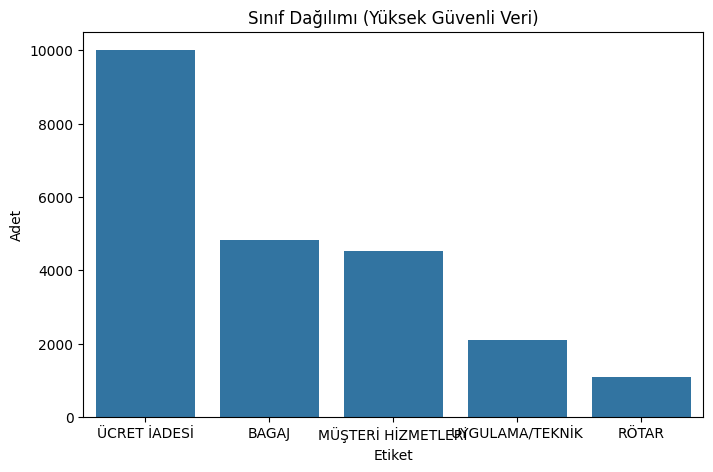

,count
predicted_label,
ÜCRET İADESİ,10009
BAGAJ,4832
MÜŞTERİ HİZMETLERİ,4515
UYGULAMA/TEKNİK,2093
RÖTAR,1097


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Veri yükleme
path = "/content/drive/MyDrive/BİTİRME/Unlabeled_Data_high_conf.xlsx"
df = pd.read_excel(path)

# 2️⃣ Sütunları kontrol et
print("✅ Sütunlar:", df.columns.tolist())

# 3️⃣ En yüksek olasılığa sahip sütunu etiket olarak belirle
etiket_sutunlari = ['ÜCRET İADESİ', 'BAGAJ', 'MÜŞTERİ HİZMETLERİ', 'UYGULAMA/TEKNİK', 'RÖTAR']

# En yüksek değeri alan sütunu predicted_label yap
df['predicted_label'] = df[etiket_sutunlari].idxmax(axis=1)

# 4️⃣ Sınıf dağılımı
plt.figure(figsize=(8,5))
sns.countplot(x='predicted_label', data=df, order=df['predicted_label'].value_counts().index)
plt.title("Sınıf Dağılımı (Yüksek Güvenli Veri)")
plt.xlabel("Etiket")
plt.ylabel("Adet")
plt.show()

# 5️⃣ Kontrol
df['predicted_label'].value_counts()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ========================================================
# 1️⃣ Kütüphaneler
# ========================================================
!pip install deep-translator -q
from deep_translator import GoogleTranslator
import pandas as pd
import numpy as np
from tqdm import tqdm
import random

# ========================================================
# 2️⃣ Yüksek güvenli veriyi oku
# ========================================================
df = pd.read_excel("/content/drive/MyDrive/BİTİRME/Unlabeled_Data_high_conf.xlsx")

# Hedef sınıflar ve kaç örnek istiyoruz (örnek: her sınıf 5000'e tamamlanacak)
target_counts = {
    'RÖTAR': 4000
}

TEXT_COLUMN = 'temizlenmis_metin'

# ========================================================
# 3️⃣ Back-Translation ile veri artırma
# ========================================================
def back_translate(text, src='tr', tmp='en', trg='tr'):
    try:
        translated = GoogleTranslator(source=src, target=tmp).translate(text)
        back_translated = GoogleTranslator(source=tmp, target=trg).translate(translated)
        return back_translated
    except:
        return text  # hata olursa orijinalini döndür

augmented_rows = []

for col, target_count in target_counts.items():
    current_rows = df[df[col]==1]
    n_current = len(current_rows)
    n_to_generate = target_count - n_current
    print(f"{col}: mevcut={n_current}, üretilecek={n_to_generate}")

    if n_to_generate > 0:
        for _ in tqdm(range(n_to_generate)):
            row = current_rows.sample(1).iloc[0]
            new_text = back_translate(row[TEXT_COLUMN])

            # yeni satır oluştur
            new_row = row.copy()
            new_row[TEXT_COLUMN] = new_text
            augmented_rows.append(new_row)

# ========================================================
# 4️⃣ Oluşturulan satırları DataFrame’e ekle
# ========================================================
if augmented_rows:
    df_augmented = pd.DataFrame(augmented_rows)
    df_combined = pd.concat([df, df_augmented], ignore_index=True)
else:
    df_combined = df.copy()

print(f"✅ Toplam satır sayısı: {len(df_combined)}")

# ========================================================
# 5️⃣ Kaydet
# ========================================================
df_combined.to_excel("/content/drive/MyDrive/BİTİRME/HighConf_BackTranslated.xlsx", index=False)
print("✅ Back-translation ile artırılmış veri kaydedildi.")


RÖTAR: mevcut=2734, üretilecek=1266


  2%|▏         | 21/1266 [00:16<20:54,  1.01s/it]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install openpyxl -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 11.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Dosya yolu
file_path = "/content/drive/MyDrive/BİTİRME/HighConf_BackTranslated.xlsx"

# Dosyayı oku
df = pd.read_excel(file_path)

# Toplam satır sayısı
print(f"✅ Satır sayısı: {len(df)}")

# Sütunları ve sınıf sütunlarını kontrol et
print(f"✅ Sütunlar: {df.columns.tolist()}")

# Sınıf dağılımı
class_cols = ['RÖTAR', 'UYGULAMA/TEKNİK', 'BAGAJ', 'ÜCRET İADESİ', 'MÜŞTERİ HİZMETLERİ']
for col in class_cols:
    if col in df.columns:
        print(f"{col}: {df[col].sum()}")


✅ Satır sayısı: 23812
✅ Sütunlar: ['Baslik', 'Icerik', 'metin', 'temizlenmis_metin', 'ÜCRET İADESİ', 'BAGAJ', 'MÜŞTERİ HİZMETLERİ', 'UYGULAMA/TEKNİK', 'RÖTAR']
RÖTAR: 4000
UYGULAMA/TEKNİK: 5188
BAGAJ: 5902
ÜCRET İADESİ: 10698
MÜŞTERİ HİZMETLERİ: 7984


In [ ]:
# ========================================================
# 1️⃣ Kütüphaneler
# ========================================================
!pip install deep-translator -q
from deep_translator import GoogleTranslator
import pandas as pd
import numpy as np
from tqdm import tqdm
import random

# ========================================================
# 2️⃣ Yüksek güvenli veriyi oku
# ========================================================
df = pd.read_excel("/content/drive/MyDrive/BİTİRME/HighConf_BackTranslated.xlsx")

# Hedef sınıflar ve kaç örnek istiyoruz (örnek: her sınıf 5000'e tamamlanacak)
target_counts = {
    'RÖTAR': 7500
}

TEXT_COLUMN = 'temizlenmis_metin'

# ========================================================
# 3️⃣ Back-Translation ile veri artırma
# ========================================================
def back_translate(text, src='tr', tmp='en', trg='tr'):
    try:
        translated = GoogleTranslator(source=src, target=tmp).translate(text)
        back_translated = GoogleTranslator(source=tmp, target=trg).translate(translated)
        return back_translated
    except:
        return text  # hata olursa orijinalini döndür

augmented_rows = []

for col, target_count in target_counts.items():
    current_rows = df[df[col]==1]
    n_current = len(current_rows)
    n_to_generate = target_count - n_current
    print(f"{col}: mevcut={n_current}, üretilecek={n_to_generate}")

    if n_to_generate > 0:
        for _ in tqdm(range(n_to_generate)):
            row = current_rows.sample(1).iloc[0]
            new_text = back_translate(row[TEXT_COLUMN])

            # yeni satır oluştur
            new_row = row.copy()
            new_row[TEXT_COLUMN] = new_text
            augmented_rows.append(new_row)

# ========================================================
# 4️⃣ Oluşturulan satırları DataFrame’e ekle
# ========================================================
if augmented_rows:
    df_augmented = pd.DataFrame(augmented_rows)
    df_combined = pd.concat([df, df_augmented], ignore_index=True)
else:
    df_combined = df.copy()

print(f"✅ Toplam satır sayısı: {len(df_combined)}")

# ========================================================
# 5️⃣ Kaydet
# ========================================================
df_combined.to_excel("/content/drive/MyDrive/BİTİRME/HighConf_BackTranslated_p2.xlsx", index=False)
print("✅ Back-translation ile artırılmış veri kaydedildi.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 4.4 MB/s eta 0:00:00
RÖTAR: mevcut=4000, üretilecek=3500


100%|██████████| 3500/3500 [36:01<00:00,  1.62it/s]


✅ Toplam satır sayısı: 27312
✅ Back-translation ile artırılmış veri kaydedildi.


In [ ]:
# ========================================================
# 1️⃣ Kütüphaneler
# ========================================================
!pip install deep-translator -q
from deep_translator import GoogleTranslator
import pandas as pd
import numpy as np
from tqdm import tqdm
import random

# ========================================================
# 2️⃣ Yüksek güvenli veriyi oku
# ========================================================
df = pd.read_excel("/content/drive/MyDrive/BİTİRME/HighConf_BackTranslated_p2.xlsx")

# Hedef sınıflar ve kaç örnek istiyoruz (örnek: her sınıf 5000'e tamamlanacak)
target_counts = {
    'BAGAJ': 7500
}

TEXT_COLUMN = 'temizlenmis_metin'

# ========================================================
# 3️⃣ Back-Translation ile veri artırma
# ========================================================
def back_translate(text, src='tr', tmp='en', trg='tr'):
    try:
        translated = GoogleTranslator(source=src, target=tmp).translate(text)
        back_translated = GoogleTranslator(source=tmp, target=trg).translate(translated)
        return back_translated
    except:
        return text  # hata olursa orijinalini döndür

augmented_rows = []

for col, target_count in target_counts.items():
    current_rows = df[df[col]==1]
    n_current = len(current_rows)
    n_to_generate = target_count - n_current
    print(f"{col}: mevcut={n_current}, üretilecek={n_to_generate}")

    if n_to_generate > 0:
        for _ in tqdm(range(n_to_generate)):
            row = current_rows.sample(1).iloc[0]
            new_text = back_translate(row[TEXT_COLUMN])

            # yeni satır oluştur
            new_row = row.copy()
            new_row[TEXT_COLUMN] = new_text
            augmented_rows.append(new_row)

# ========================================================
# 4️⃣ Oluşturulan satırları DataFrame’e ekle
# ========================================================
if augmented_rows:
    df_augmented = pd.DataFrame(augmented_rows)
    df_combined = pd.concat([df, df_augmented], ignore_index=True)
else:
    df_combined = df.copy()

print(f"✅ Toplam satır sayısı: {len(df_combined)}")

# ========================================================
# 5️⃣ Kaydet
# ========================================================
df_combined.to_excel("/content/drive/MyDrive/BİTİRME/HighConf_BackTranslated_p3.xlsx", index=False)
print("✅ Back-translation ile artırılmış veri kaydedildi.")


BAGAJ: mevcut=5922, üretilecek=1578


100%|██████████| 1578/1578 [17:37<00:00,  1.49it/s]


✅ Toplam satır sayısı: 28890
✅ Back-translation ile artırılmış veri kaydedildi.


In [ ]:
# ========================================================
# 1️⃣ Kütüphaneler
# ========================================================
!pip install deep-translator -q
from deep_translator import GoogleTranslator
import pandas as pd
import numpy as np
from tqdm import tqdm
import random

# ========================================================
# 2️⃣ Yüksek güvenli veriyi oku
# ========================================================
df = pd.read_excel("/content/drive/MyDrive/BİTİRME/HighConf_BackTranslated_p3.xlsx")

# Hedef sınıflar ve kaç örnek istiyoruz (örnek: her sınıf 5000'e tamamlanacak)
target_counts = {
    'UYGULAMA/TEKNİK': 7500
}

TEXT_COLUMN = 'temizlenmis_metin'

# ========================================================
# 3️⃣ Back-Translation ile veri artırma
# ========================================================
def back_translate(text, src='tr', tmp='en', trg='tr'):
    try:
        translated = GoogleTranslator(source=src, target=tmp).translate(text)
        back_translated = GoogleTranslator(source=tmp, target=trg).translate(translated)
        return back_translated
    except:
        return text  # hata olursa orijinalini döndür

augmented_rows = []

for col, target_count in target_counts.items():
    current_rows = df[df[col]==1]
    n_current = len(current_rows)
    n_to_generate = target_count - n_current
    print(f"{col}: mevcut={n_current}, üretilecek={n_to_generate}")

    if n_to_generate > 0:
        for _ in tqdm(range(n_to_generate)):
            row = current_rows.sample(1).iloc[0]
            new_text = back_translate(row[TEXT_COLUMN])

            # yeni satır oluştur
            new_row = row.copy()
            new_row[TEXT_COLUMN] = new_text
            augmented_rows.append(new_row)

# ========================================================
# 4️⃣ Oluşturulan satırları DataFrame’e ekle
# ========================================================
if augmented_rows:
    df_augmented = pd.DataFrame(augmented_rows)
    df_combined = pd.concat([df, df_augmented], ignore_index=True)
else:
    df_combined = df.copy()

print(f"✅ Toplam satır sayısı: {len(df_combined)}")

# ========================================================
# 5️⃣ Kaydet
# ========================================================
df_combined.to_excel("/content/drive/MyDrive/BİTİRME/HighConf_BackTranslated_p4.xlsx", index=False)
print("✅ Back-translation ile artırılmış veri kaydedildi.")


UYGULAMA/TEKNİK: mevcut=5368, üretilecek=2132


100%|██████████| 2132/2132 [27:58<00:00,  1.27it/s]


✅ Toplam satır sayısı: 31022
✅ Back-translation ile artırılmış veri kaydedildi.


In [ ]:
import pandas as pd

# ========================================================
# 1️⃣ Veri yükle
# ========================================================
df = pd.read_excel("/content/drive/MyDrive/BİTİRME/HighConf_BackTranslated_p4.xlsx")

etiketler = ['ÜCRET İADESİ', 'BAGAJ', 'MÜŞTERİ HİZMETLERİ', 'UYGULAMA/TEKNİK', 'RÖTAR']

# ========================================================
# 2️⃣ Hedefler
# ========================================================
hedefler = {
    'ÜCRET İADESİ': 8000
    # MÜŞTERİ HİZMETLERİ'ni artık azaltmayacağız
}

# ========================================================
# 3️⃣ Multi-etiketli satırları koru
# ========================================================
korunacak = (df['BAGAJ'] == 1) | (df['RÖTAR'] == 1) | (df['UYGULAMA/TEKNİK'] == 1)
df_korunan = df[korunacak].copy()
df_azalt = df[~korunacak].copy()

print(f"Korunan satır sayısı: {len(df_korunan)}")
print(f"Azaltılabilir satır sayısı: {len(df_azalt)}")

# ========================================================
# 4️⃣ Sadece ÜCRET İADESİ azalt
# ========================================================
etiket = 'ÜCRET İADESİ'
hedef = hedefler[etiket]
mevcut = int(df[df[etiket] == 1].shape[0])

if mevcut > hedef:
    fazla_sayi = mevcut - hedef
    adaylar = df_azalt[df_azalt[etiket] == 1]
    print(f"\n{etiket}: mevcut={mevcut}, azaltılacak={fazla_sayi}")

    if len(adaylar) > fazla_sayi:
        silinecek = adaylar.sample(n=fazla_sayi, random_state=42)
        df_azalt = df_azalt.drop(silinecek.index)
    else:
        print("⚠️ Yeterli tek etiketli aday yok, mümkün olan kadar azaltılacak.")

# ========================================================
# 5️⃣ Sonuç birleştir
# ========================================================
son_df = pd.concat([df_korunan, df_azalt], ignore_index=True)

print("\n✅ Yeni etiket dağılımı:")
print(son_df[etiketler].sum())
print(f"✅ Toplam satır sayısı: {len(son_df)}")

# ========================================================
# 6️⃣ Kaydet
# ========================================================
output_path = "/content/drive/MyDrive/BİTİRME/HighConf_Reduced_p7.xlsx"
son_df.to_excel(output_path, index=False)
print(f"\n✅ Kaydedildi: {output_path}")


Korunan satır sayısı: 21683
Azaltılabilir satır sayısı: 9339

ÜCRET İADESİ: mevcut=13465, azaltılacak=5465

✅ Yeni etiket dağılımı:
ÜCRET İADESİ          8000
BAGAJ                 7811
MÜŞTERİ HİZMETLERİ    6673
UYGULAMA/TEKNİK       7500
RÖTAR                 7513
dtype: int64
✅ Toplam satır sayısı: 25557

✅ Kaydedildi: /content/drive/MyDrive/BİTİRME/HighConf_Reduced_p7.xlsx


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# =====================================================
# 0️⃣ Kütüphaneler
# =====================================================
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score, classification_report
import pandas as pd
import os

# =====================================================
# 1️⃣ Dosyaları yükle
# =====================================================
train_1k = pd.read_excel("/content/drive/MyDrive/BİTİRME/train_augmented_multi_label_balanced.xlsx")
high_conf = pd.read_excel("/content/drive/MyDrive/BİTİRME/HighConf_Reduced_p7.xlsx")

# =====================================================
# 2️⃣ Gereksiz sütunları temizle
# =====================================================
for df in [train_1k, high_conf]:
    if 'Baslik' in df.columns: df.drop(columns=['Baslik'], inplace=True)
    if 'Icerik' in df.columns: df.drop(columns=['Icerik'], inplace=True)

TEXT_COLUMN = 'temizlenmis_metin'
ANA_KATEGORILER = ['ÜCRET İADESİ','BAGAJ','MÜŞTERİ HİZMETLERİ','UYGULAMA/TEKNİK','RÖTAR']

# =====================================================
# 3️⃣ 1k modeli warm-start olarak yükle
# =====================================================
MODEL_PATH_1K = '/content/drive/MyDrive/BİTİRME/trained_bert_multi_label'
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH_1K)
model = BertForSequenceClassification.from_pretrained(MODEL_PATH_1K, num_labels=len(ANA_KATEGORILER))

# =====================================================
# 4️⃣ High-conf ve 1k veriyi birleştir
# =====================================================
combined_df = pd.concat([train_1k, high_conf], ignore_index=True)
texts = combined_df[TEXT_COLUMN]
labels = combined_df[ANA_KATEGORILER]

# =====================================================
# 5️⃣ Dataset sınıfı
# =====================================================
class ComplaintDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

dataset = ComplaintDataset(texts, labels, tokenizer)
val_size = int(0.1*len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# =====================================================
# 6️⃣ Custom Trainer
# =====================================================
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(pred):
    labels = pred.label_ids
    preds = torch.sigmoid(torch.tensor(pred.predictions)).numpy()
    preds_binary = (preds > 0.5).astype(int)
    f1 = f1_score(labels, preds_binary, average='micro')
    acc = accuracy_score(labels, preds_binary)
    return {"f1": f1, "accuracy": acc}

# =====================================================
# 7️⃣ Eğitim parametreleri ve cihaz
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/BİTİRME/results_finetune',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/BİTİRME/logs_finetune',
    logging_steps=50,
    report_to='none',
    fp16=True if device.type=='cuda' else False
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# =====================================================
# 8️⃣ Fine-tune başlat
# =====================================================
print("\n✅ Fine-tune başlatılıyor...")
trainer.train()

# =====================================================
# 9️⃣ Model ve tokenizer kaydet
# =====================================================
save_path = '/content/drive/MyDrive/BİTİRME/trained_bert_finetuned'
os.makedirs(save_path, exist_ok=True)
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"\n✅ Fine-tuned model ve tokenizer '{save_path}' klasörüne kaydedildi.")



✅ Fine-tune başlatılıyor...


Step,Training Loss
50,0.090200
100,0.065400
150,0.067300
200,0.057000
250,0.069200
300,0.077100
350,0.053200
400,0.089000
450,0.066100
500,0.067300



✅ Fine-tuned model ve tokenizer '/content/drive/MyDrive/BİTİRME/trained_bert_finetuned' klasörüne kaydedildi.


In [ ]:
import numpy as np
import os
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os

metrics_dir = "/content/drive/MyDrive/BİTİRME/metrics2"
os.makedirs(metrics_dir, exist_ok=True)  # Klasör yoksa oluştur

# Şimdi metrikleri kaydedebilirsin
metrics_file = os.path.join(metrics_dir, "multi_label_metrics.txt")
with open(metrics_file, "w") as f:
    for k,v in metrics_dict.items():
        f.write(f"{k}: {v:.4f}\n")


# ====== Kaydedilecek klasör ======
metrics_dir = "/content/drive/MyDrive/BİTİRME/metrics2"
os.makedirs(metrics_dir, exist_ok=True)

# ====== Modeli eval moduna al ======
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for item in val_dataset:
        input_ids = item['input_ids'].unsqueeze(0).to(device)
        attention_mask = item['attention_mask'].unsqueeze(0).to(device)
        labels = item['labels'].unsqueeze(0).to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.sigmoid(logits)
        preds_binary = (preds > 0.5).float()

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds_binary.cpu().numpy())

# Numpy array’e çevir
all_labels = np.vstack(all_labels)
all_preds = np.vstack(all_preds)

# ====== Temel metrikler ======
f1_micro = f1_score(all_labels, all_preds, average='micro')
f1_macro = f1_score(all_labels, all_preds, average='macro')
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')

metrics_dict = {
    "Accuracy": accuracy,
    "Precision_micro": precision,
    "Recall_micro": recall,
    "F1_micro": f1_micro,
    "F1_macro": f1_macro
}

# Metrikleri TXT olarak kaydet
metrics_file = os.path.join(metrics_dir, "multi_label_metrics.txt")
with open(metrics_file, "w") as f:
    for k,v in metrics_dict.items():
        f.write(f"{k}: {v:.4f}\n")

print(f"✅ Metrikler kaydedildi: {metrics_file}")

# ====== Confusion Matrix her etiket için ======
mcm = multilabel_confusion_matrix(all_labels, all_preds)

for idx, cm in enumerate(mcm):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Label {ANA_KATEGORILER[idx]}")

    # Güvenli dosya adı
    safe_label = ANA_KATEGORILER[idx].replace("/", "_").replace(" ", "_")
    plt.savefig(os.path.join(metrics_dir, f"confusion_matrix_{safe_label}.png"))
    plt.close()

print(f"✅ Confusion matrix görselleri kaydedildi: {metrics_dir}")


✅ Metrikler kaydedildi: /content/drive/MyDrive/BİTİRME/metrics2/multi_label_metrics.txt
✅ Confusion matrix görselleri kaydedildi: /content/drive/MyDrive/BİTİRME/metrics2


In [ ]:
import numpy as np
import os
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# ====== Klasör ======
metrics_dir = "/content/drive/MyDrive/BİTİRME/metrics2"
os.makedirs(metrics_dir, exist_ok=True)

# ====== Modeli eval moduna al ======
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for item in val_dataset:
        input_ids = item['input_ids'].unsqueeze(0).to(device)
        attention_mask = item['attention_mask'].unsqueeze(0).to(device)
        labels = item['labels'].unsqueeze(0).to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.sigmoid(logits)
        preds_binary = (preds > 0.5).float()

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds_binary.cpu().numpy())

all_labels = np.vstack(all_labels)
all_preds = np.vstack(all_preds)

# ====== Temel metrikler ======
f1_micro = f1_score(all_labels, all_preds, average='micro')
f1_macro = f1_score(all_labels, all_preds, average='macro')
accuracy = accuracy_score(all_labels, all_preds)
precision_micro = precision_score(all_labels, all_preds, average='micro')
recall_micro = recall_score(all_labels, all_preds, average='micro')

# ====== Sınıf bazlı metrikler ======
precision_per_class = precision_score(all_labels, all_preds, average=None)
recall_per_class = recall_score(all_labels, all_preds, average=None)
f1_per_class = f1_score(all_labels, all_preds, average=None)

metrics_dict = {
    "Accuracy": accuracy,
    "Precision_micro": precision_micro,
    "Recall_micro": recall_micro,
    "F1_micro": f1_micro,
    "F1_macro": f1_macro
}

# Sınıf bazlı metrikleri ekle
for idx, label in enumerate(ANA_KATEGORILER):
    metrics_dict[f"Precision_{label}"] = precision_per_class[idx]
    metrics_dict[f"Recall_{label}"] = recall_per_class[idx]
    metrics_dict[f"F1_{label}"] = f1_per_class[idx]

# ====== TXT olarak kaydet ======
metrics_file = os.path.join(metrics_dir, "multi_label_metrics.txt")
with open(metrics_file, "w") as f:
    for k,v in metrics_dict.items():
        f.write(f"{k}: {v:.4f}\n")
print(f"✅ Metrikler kaydedildi: {metrics_file}")

# ====== Multi-label confusion matrix her label ======
mcm = multilabel_confusion_matrix(all_labels, all_preds)
for idx, cm in enumerate(mcm):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Label {ANA_KATEGORILER[idx]}")
    safe_label = ANA_KATEGORILER[idx].replace("/", "_").replace(" ", "_")
    plt.savefig(os.path.join(metrics_dir, f"confusion_matrix_{safe_label}.png"))
    plt.close()

# ====== Tüm sınıflar için 5x5 confusion matrix ======
# Not: Multi-label ise overlap olacağı için her label 1/0, 5x5 klasik confusion matrix mantığı biraz farklı
# Ama burada "en baskın etiket" varsayımı ile tek-label gibi gösterebiliriz:
true_labels_single = np.argmax(all_labels, axis=1)
pred_labels_single = np.argmax(all_preds, axis=1)

cm_full = confusion_matrix(true_labels_single, pred_labels_single)
plt.figure(figsize=(6,5))
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', xticklabels=ANA_KATEGORILER, yticklabels=ANA_KATEGORILER)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - All Classes")
plt.savefig(os.path.join(metrics_dir, "confusion_matrix_all_classes.png"))
plt.close()
print(f"✅ 5x5 Confusion matrix kaydedildi: {metrics_dir}")


✅ Metrikler kaydedildi: /content/drive/MyDrive/BİTİRME/metrics2/multi_label_metrics.txt
✅ 5x5 Confusion matrix kaydedildi: /content/drive/MyDrive/BİTİRME/metrics2


In [ ]:
# =========================================================
# 1️⃣ Drive'ı Bağla
# =========================================================
from google.colab import drive
drive.mount('/content/drive')

# =========================================================
# 2️⃣ Model Yolunu Belirt
# =========================================================
model_path = "/content/drive/MyDrive/BİTİRME/trained_bert_finetuned"

# =========================================================
# 3️⃣ Model ve Tokenizer'ı Yükle (Local)
# =========================================================
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)
model.eval()

print("✅ Model ve tokenizer başarıyla yüklendi!")

# =========================================================
# 4️⃣ Örnek Tahmin
# =========================================================
text = "Bagajımda kırıklar oluştu ve tamir edilemez durumda yenisini verin."
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=-1).item()

print("Tahmin edilen sınıf ID:", predicted_class_id)

# Eğer etiket isimlerini biliyorsan:
labels = ["ÜCRET İADESİ", "BAGAJ", "MÜŞTERİ HİZMETLERİ", "UYGULAMA/TEKNİK", "RÖTAR"]
print("Tahmin edilen etiket:", labels[predicted_class_id])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model ve tokenizer başarıyla yüklendi!
Tahmin edilen sınıf ID: 1
Tahmin edilen etiket: BAGAJ


In [ ]:
import torch

save_path = "/content/drive/MyDrive/BİTİRME/final_model.pt"
torch.save(model.state_dict(), save_path)
print("✅ Model kaydedildi:", save_path)


✅ Model kaydedildi: /content/drive/MyDrive/BİTİRME/final_model.pt


In [ ]:
!pip install flask transformers torch

from flask import Flask, request, jsonify
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# ======= MODEL PATH =======
MODEL_PATH = "/content/drive/MyDrive/BİTİRME/trained_bert_finetuned"

# ======= LABELS (etiketlerin sırası) =======
ANA_KATEGORILER = ["ÜCRET İADESİ", "BAGAJ", "MÜŞTERİ HİZMETLERİ", "UYGULAMA/TEKNİK", "RÖTAR"]

# ======= Model & Tokenizer Yükleme =======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
model = BertForSequenceClassification.from_pretrained(MODEL_PATH)
model.to(device)
model.eval()

# ======= Flask App =======
app = Flask(__name__)

@app.route("/predict", methods=["POST"])
def predict():
    data = request.get_json(force=True)
    text = data.get("text", "")

    if not text:
        return jsonify({"error": "No text provided"}), 400

    # ======= Tokenize Et =======
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()[0]

    # ======= Olasılıklar + Etiketler =======
    result = {}
    for label, p in zip(ANA_KATEGORILER, probs):
        result[label] = float(p)

    # Eşik 0.5 üzerindekileri etiket olarak ata
    predicted_labels = [label for label, p in result.items() if p > 0.5]

    return jsonify({
        "text": text,
        "predicted_labels": predicted_labels,
        "probabilities": result
    })

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
# =====================================================
# 1️⃣ Gerekli kütüphaneler
# =====================================================
!pip install transformers torch flask flask-cors
!npm install -g localtunnel

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from flask import Flask, request, jsonify
from flask_cors import CORS
import threading
import os

# =====================================================
# 2️⃣ Model ve tokenizer yükleme
# =====================================================
model_path = "/content/drive/MyDrive/BİTİRME/trained_bert_finetuned"  # senin model yolun
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenizer ve model
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

# =====================================================
# 3️⃣ Flask API
# =====================================================
app = Flask(__name__)
CORS(app)  # frontend ile iletişim için

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.json
        text = data['text']

        # Tokenize
        inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)

        # Tahmin
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.sigmoid(logits)
            preds_binary = (preds > 0.5).int().cpu().tolist()[0]

        # Sınıf isimleri (senin ANA_KATEGORILER listesi)
        ANA_KATEGORILER = ["ÜCRET İADESİ", "BAGAJ", "MÜŞTERİ HİZMETLERİ", "UYGULAMA/TEKNİK", "RÖTAR"]
        prediction_dict = {label: pred for label, pred in zip(ANA_KATEGORILER, preds_binary)}

        return jsonify({"prediction": prediction_dict})

    except Exception as e:
        return jsonify({"error": str(e)})

# =====================================================
# 4️⃣ Flask arka planda çalıştır
# =====================================================
def run_app():
    app.run(port=5009)

threading.Thread(target=run_app).start()

# =====================================================
# 5️⃣ Localtunnel ile Colab dışına aç
# =====================================================
!lt --port 5009


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋
changed 22 packages in 1s
⠋
⠋3 packages are looking for funding
⠋  run `npm fund` for details
⠋ * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5009 is in use by another program. Either identify and stop that program, or start the server with a different port.


your url is: https://crazy-walls-visit.loca.lt
^C


In [ ]:
!pip install torch transformers flask flask-cors


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

model_path = "/content/drive/MyDrive/BİTİRME/trained_bert_finetuned"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)


In [ ]:
!pip install flask-ngrok
from flask_ngrok import run_with_ngrok
